In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyfinancialdata
import pandas_techinal_indicators as ta
import trade_functions
from sklearn.ensemble import RandomForestClassifier

%load_ext autoreload
%autoreload 2

## Training data

In [2]:
train_data = pyfinancialdata.get_multi_year(
    provider='histdata',
    instrument='GRXEUR',
    years=[2010, 2011, 2012, 2013, 2014, 2015, 2016],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=False,
)

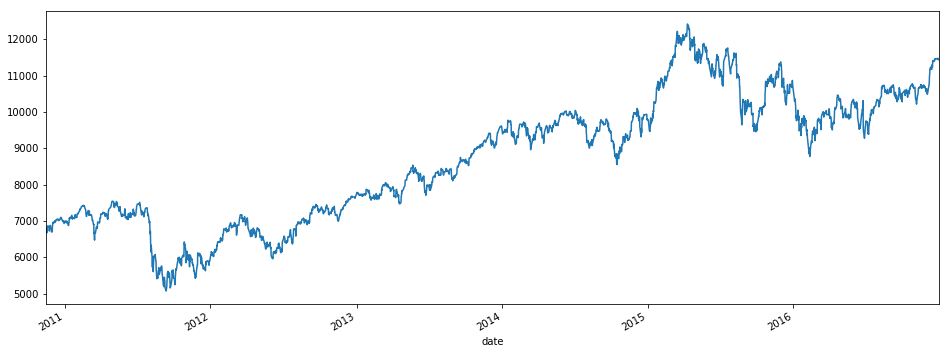

In [3]:
train_data['price'].plot(figsize=(16,6))

In [4]:
# Remove datetime index
train_data.reset_index(inplace=True)
# Add column for the direction of the next bar
# 1 = up, -1 = down
train_data['next_direction'] = np.where(train_data.shift(-1)['price'] > train_data['price'], 1, -1)

In [5]:
# Add features to help predict next_direction
def add_features(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema14'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()
        
    data = ta.macd(data, n_fast=12, n_slow=26)

    return data

In [6]:
# Add features
train_data = add_features(train_data.copy())
# Remove NA rows created from the extra features
train_data = train_data.replace([np.inf, -np.inf], np.nan)
train_data = train_data.dropna()

In [7]:
train_data.tail(5)

,date,close,high,low,open,price,next_direction,RSI_5,SO%d_5,ATR_5,...,CCI_66,Trix_66,Vortex_66,ema50,ema21,ema14,ema5,MACD_12_26,MACDsign_12_26,MACDdiff_12_26
3106,2016-12-28 12:00:00,11436.75,11460.00,11432.50,11460.00,11436.75,1,0.251469,0.289905,29.093521,...,1.351796,0.000461,0.321162,1.046069,1.021443,1.011787,0.999743,106.170295,129.551958,-23.381663
3107,2016-12-29 00:00:00,11441.50,11462.00,11412.00,11445.75,11441.50,-1,0.148460,0.389937,36.062347,...,1.295857,0.000474,0.332876,1.045550,1.020853,1.011384,1.000132,98.829516,123.407470,-24.577954
3108,2016-12-29 12:00:00,11436.75,11444.50,11429.50,11441.75,11436.75,1,0.148460,0.421069,29.041565,...,1.250553,0.000486,0.320167,1.044192,1.019482,1.010226,0.999764,91.573014,117.040578,-25.467565
3109,2016-12-30 00:00:00,11460.75,11485.25,11402.25,11455.00,11460.75,-1,0.699325,0.515652,47.027710,...,1.244743,0.000498,0.300927,1.045433,1.020619,1.011513,1.001551,86.758683,110.984199,-24.225517
3110,2016-12-30 12:00:00,11447.75,11461.00,11435.25,11460.50,11447.75,-1,0.699325,0.505581,39.935140,...,1.202212,0.000510,0.323039,1.043342,1.018560,1.009668,1.000346,80.961031,104.979566,-24.018535


In [8]:
# The features are all columns except next_direction and OHLC
features = [column for column in train_data.columns if column not in ['next_direction', 'date', 'open', 'high', 'low', 'close']]
print(features)

['price', 'RSI_5', 'SO%d_5', 'ATR_5', 'Momentum_5', 'ROC_5', 'CCI_5', 'Trix_5', 'Vortex_5', 'RSI_14', 'SO%d_14', 'ATR_14', 'Momentum_14', 'ROC_14', 'CCI_14', 'Trix_14', 'Vortex_14', 'RSI_26', 'SO%d_26', 'ATR_26', 'Momentum_26', 'ROC_26', 'CCI_26', 'Trix_26', 'Vortex_26', 'RSI_44', 'SO%d_44', 'ATR_44', 'Momentum_44', 'ROC_44', 'CCI_44', 'Trix_44', 'Vortex_44', 'RSI_66', 'SO%d_66', 'ATR_66', 'Momentum_66', 'ROC_66', 'CCI_66', 'Trix_66', 'Vortex_66', 'ema50', 'ema21', 'ema14', 'ema5', 'MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26']


## The model

In [9]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=65)
# Fit the model
X_train = train_data[features]
y_train = train_data['next_direction']
model.fit(X_train, y_train.values.ravel());

## Test data

In [10]:
test_data = pyfinancialdata.get_multi_year(
    provider='histdata',
    instrument='GRXEUR',
    years=[2017, 2018],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=False,
)

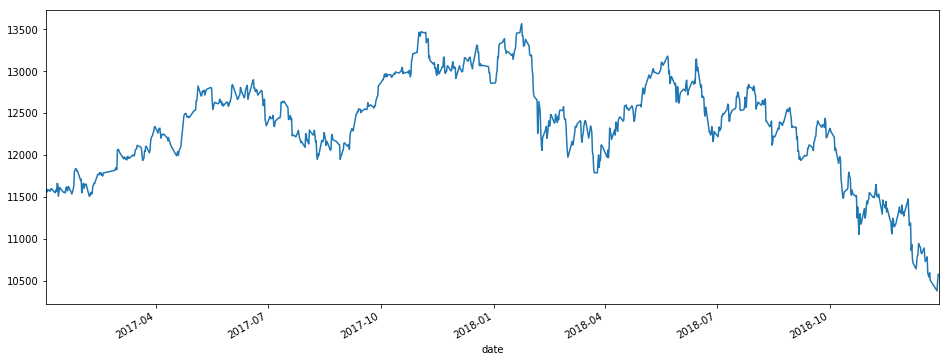

In [11]:
test_data['price'].plot(figsize=(16,6))

## Test the model

In [12]:
# Remove datetime index
test_data.reset_index(inplace=True)
# Add features
test_data = add_features(test_data.copy())
# Remove NA rows
test_data = test_data.replace([np.inf, -np.inf], np.nan)
test_data = test_data.dropna()
# Make a new blank columns for predictions
test_data['next_prediction'] = np.NaN
# Reset index
test_data.reset_index(inplace=True)

In [13]:
# Add a prediction for each row
for i in range(len(test_data)):
    test_data.at[i, 'next_prediction'] = model.predict(test_data[features].iloc[[i]])

In [14]:
test_data[['price', 'next_prediction']].tail(5)

,price,next_prediction
797,10505.31,1.0
798,10379.41,1.0
799,10497.21,1.0
800,10578.41,1.0
801,10567.61,1.0


In [15]:
test_data['next_prediction'].value_counts()

-1.0    484
 1.0    318
Name: next_prediction, dtype: int64

In [16]:
# add columns for price direction and predicted direction
test_data['next_direction'] = np.where(test_data['price'] > test_data['price'].shift(-1), -1, 1)
test_data['correct'] = test_data['next_prediction'] == test_data['next_direction']

In [17]:
# How often does the model predict the correct price change direction
test_data['correct'].value_counts()

True     402
False    400
Name: correct, dtype: int64

## Trade results

In [18]:
# Create a column for the position we should take
test_data['position'] = test_data['next_prediction']

In [19]:
trades = trade_functions.create_trades_from_positions(test_data.copy())

222 positions to plot...


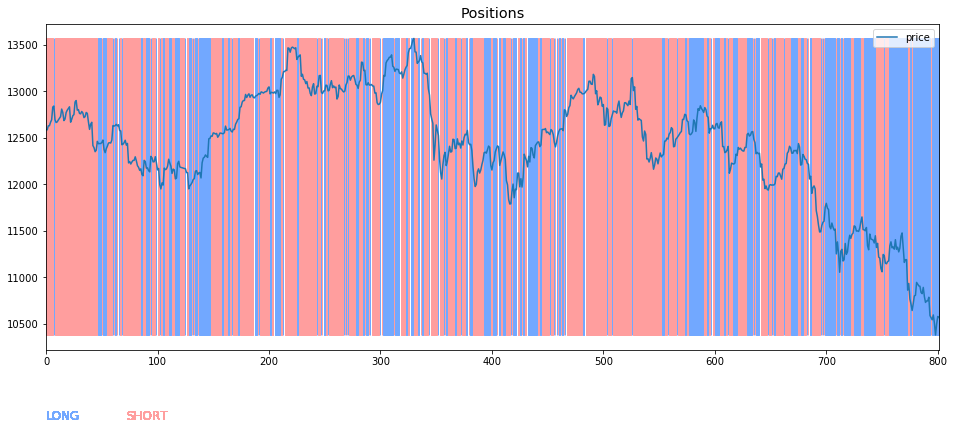

In [20]:
trade_functions.show_positions_on_price_plot(test_data.copy())

In [21]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 51.35%
Ratio of long to short positions: 1.0
Median profit: 3.5
Total profit: 1879.11
Median position length: 2.0
Number of trades: 222
